In [2]:
from plotnine import *
import requests
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import patsy
from scipy.stats import f_oneway

```python
base_url = 'http://kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=34e91f3cc43c4f3da4a996a8837d03e1'

start_date = pd.to_datetime('1990-11-11')  
end_date = pd.to_datetime('2023-05-18')    

date_range = pd.date_range(start_date, end_date, freq='D')  
movie_list = []

for date in date_range:
    target_date = date.strftime('%Y%m%d') 
    url = f'{base_url}&targetDt={target_date}'  
    
    res = requests.get(url)
    text = res.text
    
    d = json.loads(text)
    
    for b in d['boxOfficeResult']['dailyBoxOfficeList']:
        movie_list.append([b['movieNm'], b['openDt'], b['audiCnt']])



data_ = pd.DataFrame(movie_list, columns=['Movie Name', 'Opening Date', 'Audience Count'])
data_2 = pd.DataFrame(movie_list, columns=['Movie Name', 'Opening Date', 'Audience Count'])

result = pd.concat([data, data_, data_2], axis=0)
grouped_data = result.groupby(['Movie Name','Opening Date'])['Audience Count'].sum()
grouped_data = grouped_data.reset_index()

grouped_data['Opening Date'] = pd.to_datetime(grouped_data['Opening Date'],errors='coerce')
grouped_data['year'] = grouped_data['Opening Date'].dt.year
grouped_data['month'] = grouped_data['Opening Date'].dt.month

grouped_data = grouped_data.fillna(0)

grouped_data['year']=grouped_data['year'].astype('int')
grouped_data['month']=grouped_data['month'].astype('int')

df = grouped_data.drop(["Opening Date"],axis=1) 

def categorize_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'winter'
    
df['season'] = df['month'].apply(categorize_season)

df.to_csv("movie.csv")
```

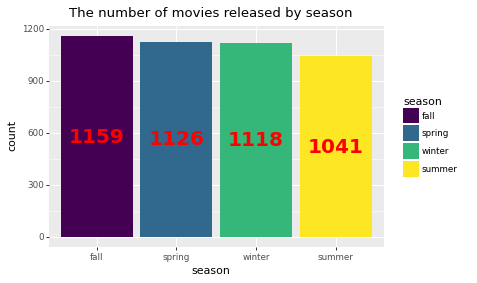

<ggplot: (8778496916273)>

In [3]:
df = pd.read_csv("movie.csv")
df['season'] = df['season'].astype(str)

counts = df['season'].value_counts().reset_index()
counts.columns = ['season', 'count']
counts['season'] = pd.Categorical(counts['season'],\
categories=counts['season'].unique(), ordered=True)


ggplot(counts, aes(x='season', y='count', fill='season')) +\
 geom_bar(stat='identity') +\
 geom_text(aes(label='count'), color='red', fontweight='bold', \
           size=20,position=position_stack(vjust=0.5)) +\
 labs(title='The number of movies released by season')

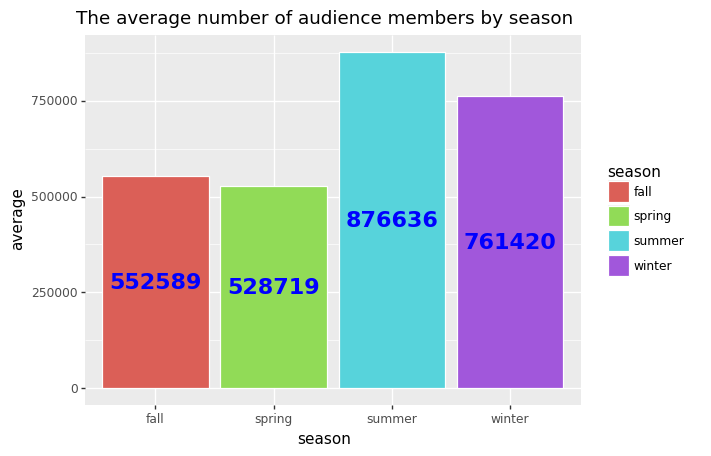

<ggplot: (8789282028279)>

In [10]:
# 계절별 관객 수의 평균을 계산합니다.
season_sum = df.groupby('season')['Audience Count'].sum()
season_count = df['season'].value_counts()
season_avg = (season_sum / season_count)
season_avg = season_avg.reset_index()
season_avg.columns = ['season', 'average']
season_avg['average'] = season_avg['average'].astype(int)  # Convert to integers


# 각 계절에 대한 색상을 정의합니다.
season_colors = {'Spring': 'green', 'Summer': \
                 'orange', 'Autumn': 'brown', 'Winter': 'blue'}

# ggplot을 사용하여 막대 그래프를 생성합니다.
ggplot(season_avg, aes(x='season', y='average', fill='season')) +\
 geom_col(color='white')+\
 geom_text(aes(label='average'), color='blue', fontweight='bold', \
           size=16,position=position_stack(vjust=0.5)) +\
 labs(title='The average number of audience members by season') 


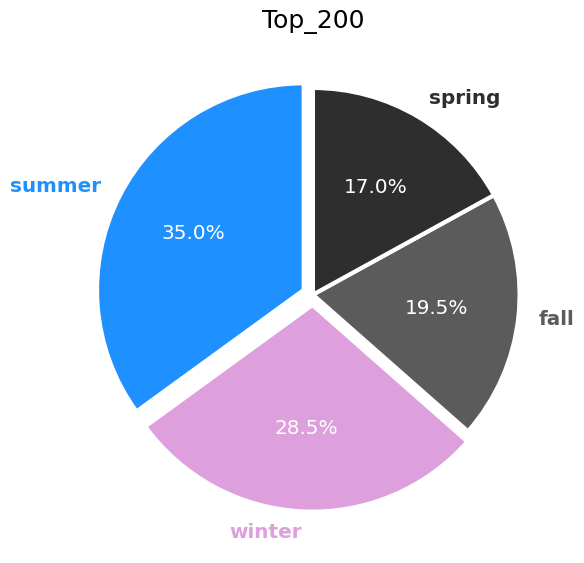

In [11]:
df = df.sort_values(by="Audience Count",ascending = False)
top_200 = df.iloc[0:200,:]['season'].value_counts()
top_200 = top_200.reset_index()
top_200.columns = ['season', 'count']
x = list(top_200.iloc[:,1])
labels = list(list(top_200.iloc[:,0]))
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, len(x))))
colors[0] = 'dodgerblue'
colors[1] = 'plum'
patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05, 0, 0))
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('Top_200', fontsize=18)
plt.tight_layout()

In [5]:
spring= df[df['season'] == 'spring']['Audience Count']
summer = df[df['season'] == 'summer']['Audience Count']
fall = df[df['season'] == 'fall']['Audience Count']
winter = df[df['season'] == 'winter']['Audience Count']

In [12]:
from scipy import stats

# 변수들을 리스트로 저장
variables = [spring, summer, fall, winter]

# 변수들에 대해 검정 수행
seasons = ['spring', 'summer', 'fall', 'winter']
for season, data in zip(seasons, variables):
    _, shapiro_p_value = stats.shapiro(data)
    _, dagostino_p_value = stats.normaltest(data)
    
    print(f"Season: {season}")
    print("Shapiro-Wilk test p-value:", shapiro_p_value)
    print("D'Agostino-Pearson's test p-value:", dagostino_p_value)
    print()


Season: spring
Shapiro-Wilk test p-value: 0.0
D'Agostino-Pearson's test p-value: 3.459260203666199e-268

Season: summer
Shapiro-Wilk test p-value: 0.0
D'Agostino-Pearson's test p-value: 5.978725023249001e-188

Season: fall
Shapiro-Wilk test p-value: 0.0
D'Agostino-Pearson's test p-value: 3.2421859965849174e-250

Season: winter
Shapiro-Wilk test p-value: 0.0
D'Agostino-Pearson's test p-value: 1.8069926618537352e-237



In [15]:
# Levene's test
levene_statistic, levene_p_value = stats.levene(spring,summer, fall, winter)
print("\nLevene's test p-value:", levene_p_value)

# Bartlett's test
bartlett_statistic, bartlett_p_value = stats.bartlett(spring,summer, fall, winter)
print("\nBartlett's test p-value:", bartlett_p_value)



Levene's test p-value: 2.5998167818408437e-08

Bartlett's test p-value: 2.801032575537023e-54


---

- 세 집단 이상의 평균 비교에서 가장 많이 사용되는 통계적 방법은 일원분산분석
  - 하지만 일원분산분석을 위해선 
    - 1) 반응변수가 정규분포를 따라야 하며
    - 2) 네 집단은 등분산성을 만족해야 함
    - etc
  - 위 두 셀의 결과를 보면 네 집단 모두 정규분포르 따르지 않으며 등분산성 가정도 만족하지 않음
- 하지만 통계적 검정 중 일원분산분석의 비모수적인 대안으로 크루스칼 왈리스 검정이라는 방법을 사용할 수 있음
  - 크루스칼 왈리스 검정이란?
  - 세개 이상의 독립적인 그룹 간에 순위 데이터 혹은 비정규 분포를 따르는 집단 간의 평균차이를 비교하기 위한 비모수적 방법
    - 비모수적 방법이란?
    - 통계분석에서 가정을 최소화하고 데이터의 분포에 대한 가정이나 모수적 가정이 필요하지 않는 방법
    - 모수적 방법이 좋냐 , 비모수적 방법이 좋냐는 따질 수 없고, 데이터의 특성에 따라 방법론이 달라질 뿐
    - 비모수적 검정 방법의 장점?
      - 분포 가정의 필요성 감소
      - 로버스트성 : 이상치에 민감하지 않고, 대부분의 경우에도 정확한 결과를 제공
    - 따라서 네 집단에 대해서 크루스칼 왈리스 검정을 수행하여 평균이 유의미하게 다르다고 할 수 있는지 검정해보겠음

In [16]:
# 크루스칼-왈리스 검정 수행
statistic, p_value = stats.kruskal(\
spring, summer, fall, winter)

# 결과 출력
print("검정 통계량:", statistic)
print("p-value:", p_value)


검정 통계량: 39.71994065013478
p-value: 1.2215658673768975e-08


- 만약, 한 영화가 봄에 첫 개봉후에 다른 계절에 재개봉했다면 

"봄에 개봉한 영화의 관객 수", "여름에 개봉한 영화의 관객 수", "겨울에 개봉한 영화의 관객 수"라는 세 집단에 대해서 독립성 또는 종속성을 판단하기 위해서는 집단 간의 관계와 데이터 수집 방식 등을 고려해야 합니다.

만약 세 집단이 독립적인 영화 개봉 시기에 대한 데이터라면, 각각의 영화 개봉 시기에 관객 수가 독립적으로 측정되었다고 가정할 수 있습니다. 이 경우에는 세 집단이 독립적인 관계를 가지고 있다고 판단할 수 있습니다.

반면에, 세 집단이 같은 영화에 대한 다른 시기의 관객 수를 나타내는 데이터라면, 예를 들어 영화가 봄에 개봉하고 여름에 재개봉되며 겨울에 다시 재개봉되는 경우, 이 세 집단은 종속적인 관계를 가질 수 있습니다. 즉, 한 영화의 관객 수가 다른 개봉 시기에 영향을 줄 수 있으며, 이러한 종속성이 존재할 수 있습니다.

따라서, 세 집단이 독립인지 종속인지를 판단하기 위해서는 세 집단의 데이터 수집 방식과 영화 개봉 시기 간의 관계를 고려해야 합니다. 직접적인 상황과 데이터에 대한 정보가 없는 한, 일반적인 결론을 내리기는 어렵습니다. 따라서, 세 집단이 독립인지 종속인지를 판단하기 위해서는 구체적인 상황과 데이터에 대한 정보가 필요합니다.

- 네 집단의 평균이 정말 다르다고 할 수 있는가?
  - f_oneway 함수를 통해 확인해보자
  - f_oneway
    - 일원분산분석 : 세 개 이상의 그룹 또는 조건간의 평균 차이를 비교하는 통계적 방법
    - 예를 들어, 여러 그룹의 평균간에 유의미한 차이가 있는지를 판단하는 데 사용됨
    - 여러 그룹의 데이터를 인자로 받아, 각 그룹의 평균 간에 유의미한 차이가 있는지를 검정하는 F-검정을 수행
    - F-검정?
      - 그룹간의 분산을 비교하여 평균 차이의 유의성을 평가하는 방법
      - 예를 들어 겨울의 분산과 여름의 분산은 차이가 있나?

#<회귀분석할차례>

In [ ]:
x = sorted(list(genre.iloc[:,1]),reverse=True)[0:6]
labels = ["drama","documentary","romance","comedy",\
          "noir","animation"]
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, len(x))))
colors[0] = 'darkolivegreen'
colors[1] = 'darkseagreen'
colors[2] = 'peru'
patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.0f%%',
    wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05, 0.05, 0,0,0))
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('Winter_genre_TOP 6', fontsize=15)
plt.tight_layout()

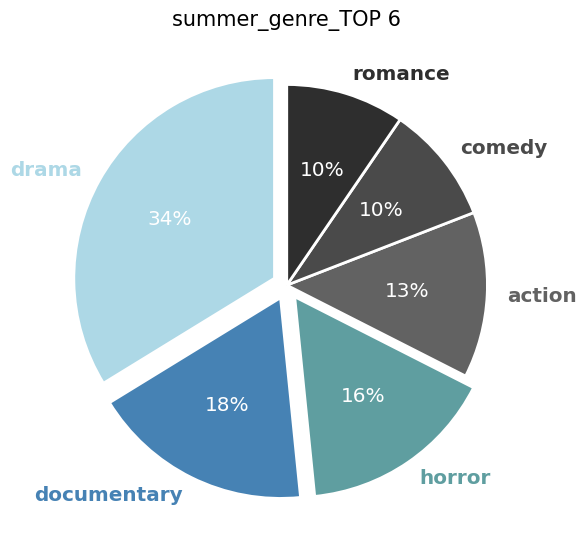

In [24]:
x = sorted(list(genre.iloc[:,3]),reverse=True)[0:6]
labels = ["drama","documentary","horror",\
          "action","comedy","romance"]
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, len(x))))
colors[0] = 'lightblue'
colors[1] = 'steelblue'
colors[2] = 'cadetblue'
patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.0f%%',
    wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90,
    colors=colors,
    explode=(0.07, 0.07, 0.07, 0,0,0))
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('summer_genre_TOP 6', fontsize=15)
plt.tight_layout()

In [ ]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [97]:
train = pd.read_csv("movies_train.csv");test = pd.read_csv("movies_test.csv")
full = pd.concat([train, test])

full['release_time'] = pd.to_datetime(full['release_time'])
full['year'] = full['release_time'].dt.year
full['month'] = full['release_time'].dt.month

def categorize_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'
    
full['season'] = full['month'].apply(categorize_season)

full = full.drop(["director","release_time"],axis=1) 
full.head()

full = full.fillna(0)

- 그냥 데이콘 보고 변수 특성 파악해서 변수이러이러해서 이러너 변순ㄴ 이렇게 변형해서 중회귀 적합하겠따
- 이때 각 변수이 특성은 설명하고 변환이유 방법에 대해 설명은하자


In [98]:
box_off_num = np.log1p(full['box_off_num'])

In [99]:
dir_prev_bfnum = np.log1p(full['dir_prev_bfnum'])

In [100]:
num_actor = np.log1p(full['num_actor'])

In [58]:
full['box_off_num'].max()

14262766.0

In [52]:
full[full['num_staff'] == 869]

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,season
372,국제시장,CJ 엔터테인먼트,드라마,126.0,12세 관람가,0.0,0.0,869.0,4.0,14262766.0,2014.0,12.0,겨울


In [47]:
selected_rows = full[full['time'] == 2015]

# time 열의 평균 계산
time_mean = full['time'].mean()

# 선택된 행의 time 값을 평균값으로 대체
selected_rows['time'] = time_mean

# 원본 데이터프레임에 변경된 행을 대체
full.update(selected_rows)


/var/folders/qj/_b9p7msx2x5d5j728xn99ps80000gn/T/ipykernel_15165/1699106939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


객 수는 왜도가 높으므로 모델링시 조정할 필요가 있습니다.

왜도가 높은 변수를 조정하는 이유는 데이터를 정규분포에 근사시키기 위함입니다.

정규분포에 근사하는 이유는 모델링시 사용할 '사이킷런'은 데이터들이 정규분포를 따른다고 가정하고 모델을 생성하기 때문에 모델의 고도화를 위해 데이터들을 정규분포에 근사시킬 필요가 있습니다.

In [73]:
full['time'].min()

40.0

In [71]:
full['time'].mean()

101.17779100512348

In [74]:
full['time'].max()

198.0

In [104]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

dummy_vars = pd.get_dummies(full[['season','screening_rat']], 
                            prefix=['season','screening_rat'], 
                            drop_first=True)
X = pd.concat([dir_prev_bfnum ,full['num_staff'],full['num_actor'], dummy_vars], axis=1)


model = sm.OLS(box_off_num, X)
results = model.fit()

print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:            box_off_num   R-squared (uncentered):                   0.649
Model:                            OLS   Adj. R-squared (uncentered):              0.645
Method:                 Least Squares   F-statistic:                              171.4
Date:                Fri, 26 May 2023   Prob (F-statistic):                   6.25e-183
Time:                        18:32:50   Log-Likelihood:                         -2592.7
No. Observations:                 843   AIC:                                      5203.
Df Residuals:                     834   BIC:                                      5246.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [86]:

test['release_time'] = pd.to_datetime(test['release_time'])
test['year'] = test['release_time'].dt.year
test['month'] = test['release_time'].dt.month

def categorize_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'
    
test['season'] = test['month'].apply(categorize_season)

test = test.drop(["director","release_time"],axis=1) 
test.head()

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month,season
0,용서는 없다,시네마서비스,느와르,125,청소년 관람불가,3.005290e+05,2,304,3,2010,1,겨울
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,113,12세 관람가,3.427002e+05,4,275,3,2010,1,겨울
2,하모니,CJ 엔터테인먼트,드라마,115,12세 관람가,4.206611e+06,3,419,7,2010,1,겨울
3,의형제,(주)쇼박스,액션,116,15세 관람가,6.913420e+05,2,408,2,2010,2,겨울
4,평행 이론,CJ 엔터테인먼트,공포,110,15세 관람가,3.173800e+04,1,380,1,2010,2,겨울


In [87]:
test[['dir_prev_bfnum']] = np.log1p(test[['dir_prev_bfnum']])

In [91]:
np.log1p(test['box_off_num'])

KeyError: 'box_off_num'

In [89]:
import numpy as np
from sklearn.metrics import mean_squared_error

dummy_vars = pd.get_dummies(test[['season','screening_rat']], 
                            prefix=['season','screening_rat'], 
                            drop_first=True)

# 테스트 데이터셋의 설명변수 데이터프레임
X_test = pd.concat([test[['dir_prev_bfnum']],\
                    test['num_staff'], test['num_actor'],\
                    dummy_vars], axis=1)

# 테스트 데이터셋의 종속변수
y_test = np.log1p(test['box_off_num'])

# 중회귀모형의 예측값 계산
y_pred = results.predict(X_test)

# 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)

# 평균 제곱근 오차(RMSE) 계산
rmse = np.sqrt(mse)

print("RMSE:", rmse)


KeyError: 'box_off_num'

In [21]:
full

,title,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,season
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,0.00,0,91,2,23398.0,2012,11,가을
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,1161602.50,2,387,3,7072501.0,2015,11,가을
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,220775.25,4,343,4,6959083.0,2013,6,여름
3,나는 공무원이다,(주)NEW,코미디,101,전체 관람가,23894.00,2,20,6,217866.0,2012,7,여름
4,불량남녀,쇼박스(주)미디어플렉스,코미디,108,15세 관람가,1.00,1,251,2,483387.0,2010,11,가을
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,78,15세 관람가,2590.00,1,4,4,0.0,2015,11,가을
239,울보 권투부,인디스토리,다큐멘터리,86,12세 관람가,0.00,0,18,2,0.0,2015,10,가을
240,어떤살인,(주)컨텐츠온미디어,느와르,107,청소년 관람불가,0.00,0,224,4,0.0,2015,10,가을
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,102,청소년 관람불가,50699.00,1,68,7,0.0,2015,10,가을


In [ ]:
full['screening_rat'].value_counts()

청소년 관람불가    297
15세 관람가     275
12세 관람가     142
전체 관람가      129
Name: screening_rat, dtype: int64

In [ ]:
full['distributor'].value_counts()

CJ 엔터테인먼트         85
롯데엔터테인먼트          76
(주)마운틴픽쳐스         43
(주)쇼박스            38
인디스토리             37
                  ..
더픽쳐스/(주)마운틴픽쳐스     1
tvN                1
와이드릴리즈(주)          1
스크린조이              1
(주)씨타마운틴픽쳐스        1
Name: distributor, Length: 204, dtype: int64

In [ ]:
full['genre'].value_counts()

드라마       299
다큐멘터리     126
멜로/로맨스    117
코미디        76
공포         61
액션         49
느와르        39
애니메이션      29
미스터리       24
SF         14
뮤지컬         6
서스펜스        3
Name: genre, dtype: int64

In [ ]:
full['dir_prev_num'].value_counts()

0    466
1    161
2    117
3     66
4     26
5      6
6      1
Name: dir_prev_num, dtype: int64

In [ ]:
full

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387.0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2590.00,1,4,4,NaN
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2,NaN
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4,NaN
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,50699.00,1,68,7,NaN


In [ ]:
genre = full.groupby('season')['genre'].value_counts().unstack().T.fillna(0)

- 장르로 회귀분석해도 된다는 증거가 된다!

- 위 df
- 아래 df
- 추카 텍슽 크롤
- 시각화?

> # 가변수 만들어서 ....................................중회귀분석해보자

> # 회귀분석 모델과 머신러닝 모델간의 예측력 비교해보자

- 시각화
- 상관관계 파악
- 회귀분석
- 분류모델
- 크롤링
  - 텍스트 지도 그리기?
  - 위 상관관계 관련해서 검색어 크롤링 해올 수 있을듯?
  - 예를 들면, 특정 기간에 어떤 영화가 흥행?
  - 그떄의 뉴스기사 토픽?
  - 날씨랑 관련이 있나? 영화 흥행이 관련이 있나?
  - 여름에 흥행했던 영화 종류가 겨울엔 흥행 못하나?
  - 계절별 흥행하는 거 시각화?
  - 가장 많이 흥행하는 장르?
  - 할 거 존나 많을 거 같은데?
    - 박근혜 탄핵될 떄? 영화 잘 팔렸어? 
    - 세월호 참사때 영화 잘 팔렸어?
  - 회귀분석할 때, 
  - 러닝타임?계절?
  - 계절별로 개봉한 영화 나눠서 평균으로 t검정 할 수도 있겠고..
  